In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
log_pd = pd.read_csv('reverb.log')


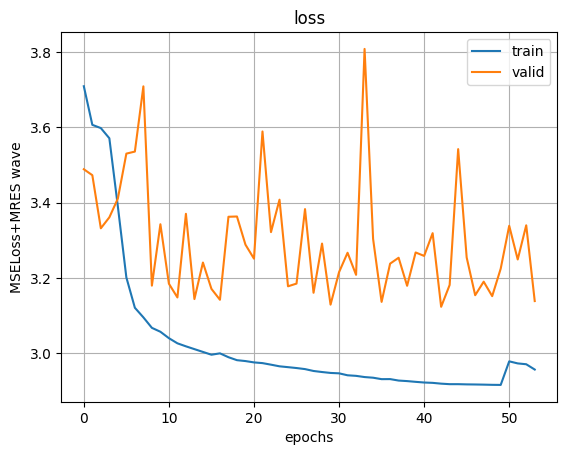

In [3]:
plt.title('loss')
plt.plot(log_pd[' train_loss'], label='train')
plt.plot(log_pd[' valid_loss'], label='valid')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MSELoss+MRES wave')
plt.grid()

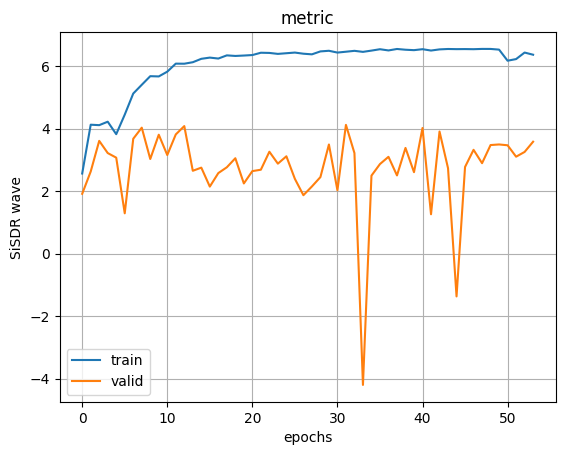

In [4]:
plt.title('metric')
plt.plot(log_pd[' train_metric'], label='train')
plt.plot(log_pd[' valid_metric'], label='valid')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('SiSDR wave')
plt.grid()

In [5]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
from Modules import STFT

In [6]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
from model import DownSample, UpSample

class Unet_model(nn.Module):
    def __init__(
        self, input_channel=1, out_channel=32, complex_input=True, log_flag=False, subband_flag=True):
        super().__init__()
        self.complex_input = complex_input
        self.log_flag = log_flag
        self.subband_flag = subband_flag
        
        self.down_1 = DownSample(
                input_channel=10,
                out_channel=64, 
                kernel_size=(4, 3), 
                stride=(4, 1),
                activation = nn.GELU(),
                normalization = nn.BatchNorm2d(64)
            )
        
        self.down_2 = DownSample(
                input_channel=64,
                out_channel=128, 
                kernel_size=(4, 3), 
                stride=(4, 1),
                activation = nn.GELU(),
                normalization = nn.BatchNorm2d(128)
            )
        
        self.lstm = nn.LSTM(input_size=256, 
                            hidden_size=256, 
                            num_layers=1, 
                            batch_first=True)
        
        
        self.up_1 = UpSample(
            input_channel=128+128, 
            out_channel=64, 
            kernel_size=(6, 3), 
            stride=(4, 1),
            activation = nn.GELU(),
            normalization = nn.BatchNorm2d(64)
        )    
        

        self.up_2 = UpSample(
            input_channel=64+64, 
            out_channel=32, 
            kernel_size=(4, 3), 
            stride=(4, 1),
            activation = nn.GELU(),
            normalization = nn.BatchNorm2d(32)
        )   
        
        
        self.fc = nn.Sequential(
            nn.Linear(40*32, 200),
            nn.Sigmoid()
        )
    
    def cac2cws(self, x):
        k = 5
        b,c,f,t = x.shape
        x = x.reshape(b,c,k,f//k,t)
        x = x.reshape(b,c*k,f//k,t)
        return x
    
    def cws2cac(self, x):
        k = 5
        b,c,f,t = x.shape
        x = x.reshape(b,c//k,k,f,t)
        x = x.reshape(b,c//k,f*k,t)
        return x
    
    def forward(self, x):
        B, C, F, T = x.shape
        
        if self.complex_input:
            x = torch.concat([x.real, x.imag], dim=1)
        elif self.log_flag:
            x = torch.log(x + 1e-5)
        
        if self.subband_flag:
            x = self.cac2cws(x)
        
        x1 = self.down_1(x)
        x2 = self.down_2(x1)        
        _, C_c, F_c, _ = x2.shape
        x = x2.view(B, -1, T).permute(0, 2, 1) # (B, C, F, T) -> (B, C*F, T) -> (B, T, C*F)
        
        x = self.lstm(x)[0] + x
        
        x = x.permute(0, 2, 1).view(B, C_c, F_c, T)
        x = self.up_1(torch.concat([x, x2],dim=1))
        x = self.up_2(torch.concat([x, x1],dim=1))
        
        x = x.view(B, -1, T).permute(0, 2, 1)
        x = self.fc(x)
        
        return x.view(B, 1, F, T)

In [7]:
from data import my_dataset

def plot_magn(magn, title):
    plt.title(title)
    plt.imshow(torch.log(magn+ 1e-5).detach(), cmap="viridis", origin="lower", aspect="auto")
    plt.show();
    
def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)

In [8]:
data_valid = my_dataset('./beam_data/valid')
data_train = my_dataset('./beam_data/train')

In [48]:
import torch as th

def pipline(model, sample):
    spec_sample = stft.stft(sample)
    B, C, F, T = spec_sample.shape
    mag = spec_sample.abs().mean(dim=1).view(B, 1, F, T)
    phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1).view(B, 1, F, T)
    mask = model(spec_sample)
    mag_predict = mag * mask
    
    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)

    z = th.complex(real, imag)
    wave_predict = stft.istft(z, sample.shape[-1])
    return wave_predict

In [49]:
unet_mask = Unet_model()
fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

In [50]:
checkpoint = torch.load('checkpoint_reverb.pt', map_location='cpu')
unet_mask.load_state_dict(checkpoint['model_state_dict'])
unet_mask.eval();

C:\Users\Максим\AppData\Local\Temp\ipykernel_4636\4164417202.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint_reverb.pt', map_location

In [61]:
predict_wave = pipline(unet_mask, data_train[60][2][None])

In [62]:
from IPython.display import Audio

Audio(data_train[1][0], rate=16000)

In [63]:
Audio(predict_wave.detach()[0], rate=16000)

In [64]:
Audio(data_train[0][2], rate=16000)

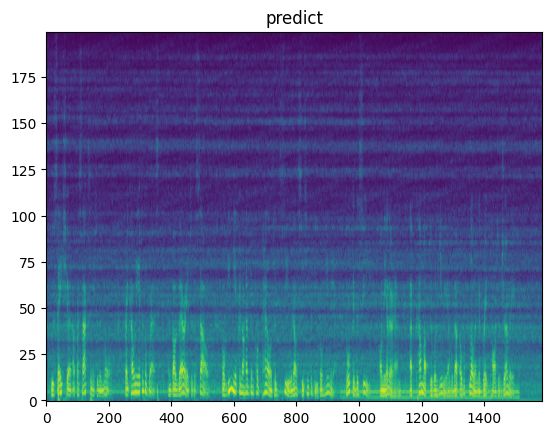

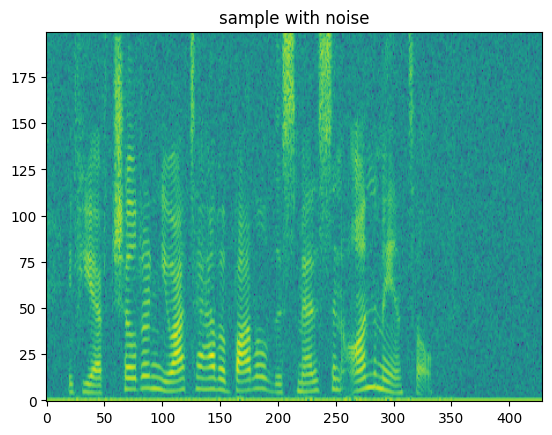

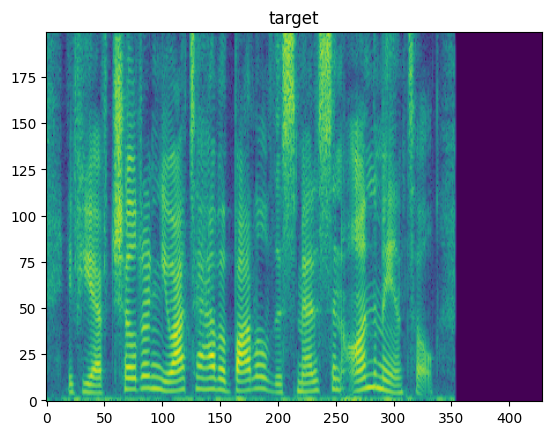

In [65]:
plot_magn(stft.stft(predict_wave.detach()[0]).abs()[0], 'predict')
plot_magn(stft.stft(data_train[0][2]).abs()[0], 'sample with noise')
plot_magn(stft.stft(data_train[0][0]).abs()[0], 'target')